## Feature Generation and Dataset Preparation

In [1]:
# Provides a way for us to save cells that we execute & test so that we can 
# use them later in our prediction code (avoids having to copy-paste code)
#
# The syntax is as follows:
# 
# %%execute_and_save <filename>

from IPython.core import magic_arguments
from IPython.core.magic import (Magics, magics_class, line_magic,
                                cell_magic, line_cell_magic)
@magics_class
class SaveScripts(Magics):

    @cell_magic
    def execute_and_save(self, line, cell):
        self.shell.run_cell(cell)
        with open(line,'w') as file:
            file.write(cell)
            
ip = get_ipython()
ip.register_magics(SaveScripts)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
font = {'weight' : 'normal',
        'size'   : 9}
mpl.rc('font', **font)
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize'] = 'medium'

In [3]:
%%execute_and_save tmp_imports

import numpy as np
import pandas as pd

import math
import os

from datetime import datetime
from datetime import timedelta

# Import our custom that retrieves financial market data from #http://financialmodelingprep.com
import api
import api.tickers as tickers  # Information about stock, ETF, etc. tickers
import api.stocks  as stocks   # Information about stocks and stock indices

from api.stocks import Stock   # Information about a particular stock
from api.stocks import Index   # Information about a particular index

from api.stocks import TIMEDELTA_QUARTER
from api.stocks import TIMEDELTA_MONTH
from api.stocks import TIMEDELTA_YEAR

from sklearn.preprocessing import MinMaxScaler

### Data Retrieval and Caching

In [4]:
sp500_tickers = tickers.get_sp500_tickers()
print("Sample S&P 500 tickers: ",sp500_tickers[:10])

Sample S&P 500 tickers:  ['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']


In [5]:
stock_data = { ticker : Stock(ticker) for ticker in sp500_tickers }

In [6]:
from IPython.display import display

def cache_stocks(start,end):
    progress = display('',display_id=True)
    success_tickers = list()
    problem_tickers = list()
    
    stock_list = list(stock_data.keys())
    for i, ticker in enumerate(stock_list):
        try:
            progress.update(f'Caching {ticker} ({i+1}/{len(stock_list)})')
            stock_data[ticker].cache_data(start,end)
            success_tickers.append(ticker)  
        except:
            problem_tickers.append(ticker)
            continue
            
    progress.update('Caching complete!')
    print(f'Cached {len(success_tickers)} tickers: {", ".join(success_tickers)}.')
    if len(problem_tickers) > 0:
        print(f'The following tickers did not have complete data and were not cached: {", ".join(problem_tickers)}.')

In [7]:
# Cache data for the last 15 quarters (90 calendar days / quarter)
end_date   = datetime.today().date()
start_date = (end_date - TIMEDELTA_QUARTER*15)

In [8]:
# This is a potentially time-intensive operation
cache_stocks(start_date,end_date)

'Caching complete!'

Cached 493 tickers: MMM, ABT, ABBV, ABMD, ACN, ATVI, ADBE, AMD, AAP, AES, AFL, A, APD, AKAM, ALK, ALB, ARE, ALXN, ALGN, ALLE, AGN, ADS, LNT, ALL, GOOGL, MO, AMZN, AMCR, AEE, AAL, AEP, AXP, AIG, T, AMT, AWK, AMP, ABC, AME, AMGN, APH, ADI, ANSS, ANTM, AON, AOS, APA, AIV, AAPL, AMAT, APTV, ADM, ARNC, ANET, AJG, AIZ, ATO, ADSK, ADP, AZO, AVB, AVY, BKR, BLL, BAC, BK, BAX, BDX, BBY, BIIB, BLK, BA, BKNG, BWA, BXP, BSX, BMY, AVGO, BR, CHRW, COG, CDNS, CPB, COF, CPRI, CAH, KMX, CCL, CAT, CBOE, CBRE, CDW, CE, CNC, CNP, CTL, CERN, CF, SCHW, CHTR, CVX, CMG, CB, CHD, CI, CINF, CTAS, CSCO, C, CFG, CTXS, CLX, CME, CMS, KO, CTSH, CL, CMCSA, CMA, CAG, CXO, COP, ED, STZ, COO, CPRT, GLW, CTVA, COST, COTY, CCI, CSX, CMI, CVS, DHI, DHR, DRI, DVA, DE, DAL, XRAY, DVN, FANG, DLR, DFS, DISCA, DISH, DG, DLTR, D, DOV, DOW, DTE, DUK, DRE, DD, DXC, ETFC, EMN, ETN, EBAY, ECL, EIX, EW, EA, EMR, ETR, EOG, EFX, EQIX, EQR, ESS, EL, EVRG, ES, RE, EXC, EXPE, EXPD, EXR, XOM, FFIV, FB, FAST, FRT, FDX, FIS, FITB, FE, FISV, 

### Feature and Label Preparation
We will want to smooth out our time-series data so that our algorithms (our neural network and calculations we perform on the time series data) are not susceptible to noise.  For instance, we do not want the neural network to learn based upon a single jump in stock price over one or just a few days in the time-series data, as what is of more interest to us is the longer-term performance of a stock (e.g., not on a day-by-day basis, but rather the performance over a quarter).

Further, simple moving averages (SMA) introduce a lag in the data where the smoothed data appears to be delayed relative to the actual trends in the time-series price data. For this reason, we will use an exponentially-weighted moving average. We can experiment with different window sizes to get some smoothing with negligible lag.

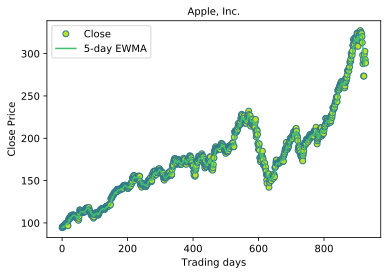

In [9]:
# Let's use Apple as an example and see what kind of window size smooths out
# data for the last quarter while generally retaining features.
aapl_data   = stock_data['AAPL'].get_historical_prices(start_date,end_date)
aapl_series = aapl_data['close']
aapl_smooth   = aapl_series.ewm(span=5).mean()

plt.plot(aapl_series.values,'.',label='Close',color=plt.cm.viridis(.4),markerfacecolor=plt.cm.viridis(.9),markersize=12)
plt.plot(aapl_smooth.values,'-',label='5-day EWMA',color=plt.cm.viridis(0.7))
plt.title('Apple, Inc.')
plt.xlabel('Trading days')
plt.ylabel('Close Price')
plt.legend();

#### Stock Labels

In [10]:
%%execute_and_save tmp_benchmark_sp500_gain

# We can use a window size of 5 to smooth out some of the noise
# while retaining fidelity with respect to the general trends
# observed in the data.

# Let's compute the gain of the S&P 500 index over the last 
# quarter. We will compare each sualtock's performance over the
# last quarte to this value.

# Note that the S&P 500 index is a capital-weighted index, so
# larger-cap stocks make up a larger portion of the fraction.
# Essentially the question we are asking is whether any given
# stock will outperform the index or "market". Investors can 
# choose to invest in index-tracking ETFs instead of a given stock.

def get_sp500_gain_for_interval(interval,offset,output=False):
    """ Get the gain for the S&P 500 over the specified interval
    
    Args:
        interval: The time interval for gain calculation as a datetime.timedelta
        offset: The offset of interval relative to today as a datetime.timedelta
        
    Returns:
        The fractional gain or loss over the interval.
    """
    end_date   = datetime.today().date()
    if offset is not None:
        end_date -= offset

    start_date = end_date - interval
    
    sp500_index = Index('^GSPC')
    sp500_time_series = sp500_index.get_historical_data(start_date,end_date)
    sp500_close = sp500_time_series['close'] 
    sp500_close_smooth = sp500_close.ewm(span=5).mean()

    sp500_end_of_interval = round(sp500_close_smooth.values[-1],2)
    sp500_start_of_interval = round(sp500_close_smooth.values[0],2)
    sp500_gain_during_interval = round(sp500_end_of_interval / sp500_start_of_interval,4)
    
    if output:
        print("Value start of interval: ",sp500_start_of_interval)
        print("Value end of interval: ",sp500_end_of_interval)
        print("Approximate gain: ",sp500_gain_during_interval)
        print("")
    
        plt.plot(sp500_close.values,'.',label='Close',color=plt.cm.viridis(.4),markerfacecolor=plt.cm.viridis(.9),markersize=12)
        plt.plot(sp500_close_smooth.values,'-',label='5-day EWMA',color=plt.cm.viridis(0.3))
        plt.title('S&P 500 Index')
        plt.xlabel('Trading days')
        plt.ylabel('Close Price')
        plt.legend()
        
    return sp500_gain_during_interval

Value start of interval:  3141.63
Value end of interval:  3031.2
Approximate gain:  0.9648



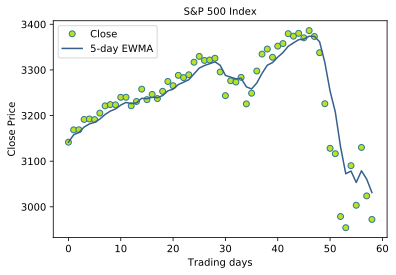

In [11]:
get_sp500_gain_for_interval(TIMEDELTA_QUARTER,offset=None,output=True);

We will need to label our data so that we can provide the labels along with training data to our neural network. The labels in this case are generated by looking at the performance of a particular stock against the "market". Since the S&P 500 is a good representation of the US market, we will compare last quarter's performance of each stock that we will use to train the network with that of the S&P 500 index.

In [12]:
%%execute_and_save tmp_benchmark_label

def get_stock_label_func(p_interval,p_offset):
    """ Generates a function that returns a stock label 
            
    Args:
        p_interval: The prediction interval as a datetime.timedelta
        p_offset: The offset of d_interval relative to today as a datetime.timedelta

    Returns:
        A function that can be called (for a specified stock) to get the stock label
    """
    ref_value = get_sp500_gain_for_interval(p_interval,p_offset,output=False) 
    
    def get_stock_label(symbol,output=False):
        """ Generates a stock label for training and/or validation dataset
            
        Raises:
            LookupError: If the stock could not be found

        Returns:
            An integer value (0 or 1) indicating the stock label
        """
        end_date = datetime.today().date()
        if p_offset is not None:
            end_date -= p_offset

        start_date = end_date - p_interval
        
        try:
            close_price = stock_data[symbol].get_historical_prices(start_date,end_date)['close']
        except:
            close_price = Stock(symbol).get_historical_prices(start_date,end_date)['close']
            
        close_price = close_price.ewm(span=3).mean()

        stock_gain = close_price.values[-1] / close_price.values[0]
        stock_relative_gain = round( (stock_gain) / ref_value,4)
        
        stock_label = 0 if stock_relative_gain < 1 else 1
        
        if output:
            print("Gain during interval: ",round(stock_gain,4))
            print("Reference value: ",ref_value)
            print("Gain relative to reference value: ",stock_relative_gain)
            print("Label: ",stock_label)
        
        return stock_label
        
    return get_stock_label

In [13]:
test_get_stock_label = get_stock_label_func(p_interval=TIMEDELTA_QUARTER,p_offset=None)

In [14]:
print('Label for AAPL: ',test_get_stock_label('AAPL'))
print('Label for KSS:  ',test_get_stock_label('KSS'))
print('Label for MSFT: ',test_get_stock_label('MSFT'))
print('Label for WELL: ',test_get_stock_label('WELL'))

Label for AAPL:  1
Label for KSS:   0
Label for MSFT:  1
Label for WELL:  0


#### Stock Features: Categorical

In [15]:
%%execute_and_save tmp_predictor_categorical

def get_stock_cat_features_func(d_interval,d_offset):
    """ Generates a function that returns categorical features for a stock
            
    Args:
        d_interval: The data interval as a datetime.timedelta (e.g., 6*TIMEDELTA_QUARTER for 6 quarters of data)
        d_offset: The offset of d_interval relative to today as a datetime.timedelta

    Returns:
        A tuple consisting of array that specifies which categorical feature are to be embedded (as opposed to 
        stand-alone features) and a function that can be called to get categorical features for a stock. The
        array should include the embedding dimension for the feature, or 0 if it is not to be embedded.
    """
    # Get list of sectors and map each sector to an index (normalized)
    sector_list = np.array(['Energy',
                            'Consumer Cyclical',
                            'Real Estate',
                            'Utilities',
                            'Industrials',
                            'Basic Materials',
                            'Technology',
                            'Healthcare',
                            'Financial Services',
                            'Consumer Defensive'])
    
    industry_list = np.array(['Agriculture',
                              'Insurance - Life',
                              'Medical Diagnostics & Research',
                              'Online Media',
                              'Oil & Gas - E&P',
                              'Homebuilding & Construction',
                              'Oil & Gas - Drilling',
                              'Oil & Gas - Refining & Marketing',
                              'Advertising & Marketing Services',
                              'Utilities - Regulated',
                              'Consulting & Outsourcing',
                              'Autos',
                              'Travel & Leisure',
                              'Oil & Gas - Integrated',
                              'Brokers & Exchanges',
                              'Application Software',
                              'Manufacturing - Apparel & Furniture',
                              'Medical Devices',
                              'Retail - Apparel & Specialty',
                              'Oil & Gas - Services',
                              'Consumer Packaged Goods',
                              'Insurance - Property & Casualty',
                              'Drug Manufacturers',
                              'Real Estate Services',
                              'Airlines',
                              'Insurance',
                              'Farm & Construction Machinery',
                              'Semiconductors',
                              'Medical Distribution',
                              'Steel',
                              'Restaurants',
                              'Waste Management',
                              'Entertainment',
                              'Chemicals',
                              'REITs',
                              'Insurance - Specialty',
                              'Metals & Mining',
                              'Retail - Defensive',
                              'Biotechnology',
                              'Conglomerates',
                              'Utilities - Independent Power Producers',
                              'Building Materials',
                              'Health Care Plans',
                              'Tobacco Products',
                              'Oil & Gas - Midstream',
                              'Transportation & Logistics',
                              'Business Services',
                              'Truck Manufacturing',
                              'Beverages - Non-Alcoholic',
                              'Personal Services',
                              'Banks',
                              'Medical Instruments & Equipment',
                              'Industrial Distribution',
                              'Asset Management',
                              'Forest Products',
                              'Industrial Products',
                              'Communication Equipment',
                              'Packaging & Containers',
                              'Credit Services',
                              'Engineering & Construction',
                              'Computer Hardware',
                              'Aerospace & Defense',
                              'Beverages - Alcoholic',
                              'Health Care Providers',
                              'Communication Services',
                              'Employment Services'])
    
    sector_dict = { sector : i for i, sector in enumerate(sector_list)}
    industry_dict = { industry : i for i, industry in enumerate(industry_list)}

    # SP500 range is on the order of USD 1B to USD 1T, scale accordingly
    MIN_MARKET_CAP = 1.0e9
    MAX_MARKET_CAP = 1.0e12
    
    # For the specified d_offset we will make a cyclic label corresponding
    # to the month of the year (1-12) using sine and cosine functions
    end_date = datetime.today().date()
    if d_offset is not None:
        end_date -= d_offset
       
    # Encoding which month (fractional) the data ends. This is universal
    # in that it will work for any intervals and offsets of interest.
    month_decimal = end_date.month + end_date.day/30.0;
    month_angle = 2*math.pi*month_decimal/12.0
    month_x = math.cos(month_angle)
    month_y = math.sin(month_angle)
    
    # The feature structure (# of embeddings for each feature or 0 if not to be embedded)
    cat_feature_embeddings = [len(sector_list)+1, len(industry_list)+1, 0, 0]
        
    def get_stock_cat_features(symbol):
        """ Gets categorical features associated with a paticular stock
        
        Args:
            symbol: A stock ticker symbol such as 'AAPL' or 'T'

        Raises:
            LookupError: If any categorical feature is unavailable of NaN for the stock.

        Returns:
            Categorical stock features as an array of M x 1 values (for M features). Categorical
            features to be embedded are appear first in the returned array
        """    
        try:
            profile = stock_data[symbol].get_company_profile()
        except:
            profile = Stock(symbol).get_company_profile()
            
        sector = profile.loc[symbol,'sector']
        industry = profile.loc[symbol,'industry']
        
        try:
            sector_feature = sector_dict[sector]
        except:
            sector_feature = len(sector_list)
            
        try:
            industry_feature = industry_dict[industry]
        except:
            industry_feature = len(industry_list)
        
        # Get market capitalization corresponding to d_offset
        if d_offset is None:
            quarter_offset = 0
        else:
            quarter_offset = int(d_offset / TIMEDELTA_QUARTER)
            
        # Get the "latest" key metrics as of the data interval
        try:
            key_metrics = stock_data[symbol].get_key_metrics(quarters=1,offset=quarter_offset)
        except:
            key_metrics = Stock(symbol).get_key_metrics(quarters=1,offset=quarter_offset)
            
        market_cap = key_metrics['Market Cap'][0]
        
        # Scalar value (approx 0-1) corresponding to market capitalization
        market_cap_feature = math.log(float(market_cap)/MIN_MARKET_CAP,MAX_MARKET_CAP/MIN_MARKET_CAP)
        
        features = np.array( [sector_feature, industry_feature, market_cap_feature, month_x, month_y],dtype='float32')
    
        if np.isnan(features).any():
            raise LookupError
            
        return features
  
    return cat_feature_embeddings, get_stock_cat_features

In [16]:
_, test_get_stock_cat_features = get_stock_cat_features_func(d_interval=4*TIMEDELTA_QUARTER,d_offset=TIMEDELTA_QUARTER)

In [17]:
test_get_stock_cat_features('AMZN')

array([6.        , 3.        , 0.99201804, 0.9848077 , 0.17364818],
      dtype=float32)

In [18]:
test_get_stock_cat_features('WELL')

array([ 2.        , 34.        ,  0.50660866,  0.9848077 ,  0.17364818],
      dtype=float32)

#### Stock Features: Daily Data

In [19]:
%%execute_and_save tmp_predictor_daily

def get_stock_daily_features_func(d_interval,d_offset):
    """ Generates a function that returns daily features for a stock
            
    Args:
        d_interval: The data interval as a datetime.timedelta (e.g., 6*TIMEDELTA_QUARTER for 6 quarters of data)
        d_offset: The offset of d_interval relative to today as a datetime.timedelta

    Returns:
        A function that can be called to get daily features for a stock
    """
    end_date = datetime.today().date()
    if d_offset is not None:
        end_date -= d_offset

    start_date = end_date - d_interval
    
    # Th S&P 500 index will have a closing value for every trading day. Each of the stocks
    # should also have the same number of values unless they were suspended and didn't trade or 
    # recently became public.
    trading_day_count = len(Index('^GSPC').get_historical_data(start_date,end_date))
    
    def get_stock_daily_features(symbol,output=False):
        """ Gets daily features associated with a paticular stock

        Args:
            symbol: A stock ticker symbol such as 'AAPL' or 'T'

        Raises:
            LookupError: If any categorical feature is unavailable of NaN for the stock.

        Returns:
            Daily stock features as an array of M x N values (for M features with N values)
        """
        try:
            historical_data = stock_data[symbol].get_historical_prices(start_date,end_date)
        except:
            historical_data = Stock(symbol).get_historical_prices(start_date,end_date)
        
        # Smooth and normalize closing price relative to initial price for data set
        close_price = historical_data['close'].ewm(span=5).mean()
        close_price = close_price / close_price.iat[0]
        close_price = np.log10(close_price)
    
        # Smooth and normalize volume relative to average volume
        average_volume = historical_data['volume'].mean()
        volume = historical_data['volume'].ewm(span=5).mean()
        volume = volume / average_volume
        volume = np.log10(volume+1e-6)
        
        # Ensure equal lengths of data (nothing missing)
        if len(volume) != len(close_price):
            raise LookupError
        
        # Ensure we have the right number of data points for the period
        if len(close_price) != trading_day_count:
            raise LookupError
        
        features = np.array([close_price, volume],dtype='float32')
        
        if np.isnan(features).any():
            raise LookupError
            
        return features
        
    return get_stock_daily_features

In [20]:
test_get_stock_daily_features = get_stock_daily_features_func(1*TIMEDELTA_QUARTER,TIMEDELTA_QUARTER)

In [21]:
test_get_stock_daily_features('AAPL')

array([[ 0.0000000e+00, -5.0990847e-03, -5.6461804e-03, -5.2436558e-03,
        -3.4641849e-03, -3.7206677e-03, -6.1305142e-03, -6.9826082e-03,
        -8.2381768e-03, -6.8057398e-03, -6.6265580e-03, -7.2191744e-03,
        -4.2070001e-03, -1.8134024e-03, -3.9086938e-03, -4.0865601e-03,
        -1.6394643e-04,  2.4616781e-03,  2.4887156e-03,  4.2007403e-03,
         7.2954437e-03,  1.3216045e-02,  1.6906137e-02,  1.9007210e-02,
         1.9813636e-02,  2.0913530e-02,  2.2342300e-02,  2.5806522e-02,
         2.7766054e-02,  3.1017344e-02,  3.3411827e-02,  3.6793131e-02,
         4.0495358e-02,  3.9547034e-02,  3.8895868e-02,  4.1715506e-02,
         4.7709335e-02,  5.2626580e-02,  5.5662919e-02,  5.7737917e-02,
         6.0354248e-02,  6.2488917e-02,  6.5058529e-02,  6.6629626e-02,
         6.9065392e-02,  6.9671363e-02,  7.1794368e-02,  7.3938005e-02,
         7.4919127e-02,  7.3878348e-02,  7.2535664e-02,  7.1511649e-02,
         7.3350571e-02,  7.3433936e-02,  7.5430177e-02,  7.64349

#### Stock Features: Quarterly Data

In [22]:
%%execute_and_save tmp_predictor_quarterly

def get_stock_quarterly_features_func(d_interval,d_offset):
    """ Generates a function that returns quarterly features for a stock
            
    Args:
        d_interval: The data interval as a datetime.timedelta (e.g., 6*TIMEDELTA_QUARTER for 6 quarters of data)
        d_offset: The offset of d_interval relative to today

    Returns:
        A function that can be called to get quarterly features for a stock
    """
    
    # Quarterly features can only be used if prediction intervals 
    if d_interval < TIMEDELTA_QUARTER:
        raise ValueError("The specified data interval is less than one quarter")
    
    end_date = datetime.today().date()    
    if d_offset is not None:
        end_date -= d_offset
        
    start_date = end_date - d_interval
    
    quarter_count =  int(d_interval / TIMEDELTA_QUARTER)
    
    if d_offset is None:
        quarter_offset = 0
    else:
        quarter_offset = int(d_offset / TIMEDELTA_QUARTER)
        
    price_to_earnings_scaler = MinMaxScaler()
    price_to_sales_scaler = MinMaxScaler()
    price_to_free_cash_flow_scaler = MinMaxScaler()
    dividend_yield_scaler = MinMaxScaler()

    price_to_earnings_scaler.fit_transform(np.array([0,200]).reshape(-1, 1))
    price_to_sales_scaler.fit_transform(np.array([0,200]).reshape(-1, 1))
    price_to_free_cash_flow_scaler.fit_transform(np.array([0,200]).reshape(-1, 1))
    dividend_yield_scaler.fit_transform(np.array([0,1]).reshape(-1, 1))
    
    def get_stock_quarterly_features(symbol):
        """ Gets quarterly features associated with a paticular stock
        
        Args:
            symbol: A stock ticker symbol such as 'AAPL' or 'T'

        Raises:
            LookupError: If any categorical feature is unavailable of NaN for the stock.

        Returns:
            Quarterly stock features as an array of M x N values (for M features and N values)
        """
        try:
            key_metrics = stock_data[symbol].get_key_metrics(quarter_count,quarter_offset)
        except:
            key_metrics = Stock(symbol).get_key_metrics(quarter_count,quarter_offset)
        
        key_metrics['PE ratio'] = price_to_earnings_scaler.transform(key_metrics['PE ratio'].values.reshape(-1,1))
        key_metrics['Price to Sales Ratio'] = price_to_sales_scaler.transform(key_metrics['Price to Sales Ratio'].values.reshape(-1,1))
        key_metrics['PFCF ratio'] = price_to_free_cash_flow_scaler.transform(key_metrics['PFCF ratio'].values.reshape(-1,1))   
        key_metrics['Dividend Yield'] = dividend_yield_scaler.transform(key_metrics['Dividend Yield'].values.reshape(-1,1))

        try:
            financials = stock_data[symbol].get_income_statement(quarter_count,quarter_offset)
        except:
            financials = Stock(symbol).get_income_statement(quarter_count,quarter_offset)
        
        # Apply scaling for diluted EPS (we want growth relative to t=0)
        financials['EPS Diluted'] = ( financials['EPS Diluted'].astype(dtype='float32') / float(financials['EPS Diluted'].iat[0]) )
    
        features = np.array([
            key_metrics['PE ratio'],
            key_metrics['Price to Sales Ratio'],
            key_metrics['PFCF ratio'],
            key_metrics['Dividend Yield'],
            financials['EPS Diluted'],
            financials['Revenue Growth'],
        ],dtype='float32')
        
        if np.isnan(features).any():
            raise LookupError
           
        return features
        
    return get_stock_quarterly_features

In [23]:
test_get_stock_quarterly_features = get_stock_quarterly_features_func(4*TIMEDELTA_QUARTER,None)

In [24]:
test_get_stock_quarterly_features('AAPL')

array([[ 0.0642785 ,  0.07975   ,  0.085186  ,  0.0935545 ],
       [ 0.0143065 ,  0.0174425 ,  0.0179    ,  0.0194515 ],
       [ 0.0602705 ,  0.074701  ,  0.0790805 ,  0.0878035 ],
       [ 0.0179    ,  0.0153    ,  0.0147    ,  0.0134    ],
       [ 1.        ,  0.88709676,  1.2217742 ,  2.0120966 ],
       [-0.3118847 , -0.07249849,  0.19013548,  0.43377575]],
      dtype=float32)

In [25]:
test_get_stock_quarterly_features('T')

array([[ 0.05007   ,  0.059608  ,  0.070231  ,  0.084843  ],
       [ 0.006082  ,  0.0065545 ,  0.006647  ,  0.007581  ],
       [ 0.0454635 ,  0.0453075 ,  0.0416045 ,  0.0477055 ],
       [ 0.0701    ,  0.0629    ,  0.0604    ,  0.0536    ],
       [ 1.        ,  0.8484848 ,  0.75757575,  0.77272725],
       [ 0.04927961, -0.06596795,  0.00290004, -0.00820784]],
      dtype=float32)

### Generate Training and Testing Data Sets

We have created a custom dataset class that will accept references to the functions we created earlier for extracting categorical, daily and quarterly features and generating a label for a particular stock. To use the dataset, we specify a list of stocks and references to the functions. We are going to create multiple datasets: training and testing datasets for a number of folds.

In [26]:
!pygmentize model/dataset.py

import torch
import torch.utils.data.dataset as dataset
import torch.utils.data.dataloader as dataLoader

from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import os

from abc import ABC

class StockDataset(dataset.Dataset,ABC):
    """Stock dataset."""
    
    def __init__(self,p_interval,d_interval,offsets,features,labels=None):

        try:
            self.c_features_embedding_dims = features[0]
            self.c_features = features[1]
            self.d_features = features[2]
            self.q_features = features[3]
            self.labels = labels
            self.p_interval = p_interval
            self.d_interval = d_interval
            self.offsets = offsets

        except:
            raise ValueError

    @classmethod
    def concat(cls,datasets):
        """ Concatenates datasets to make a new dataset (for use with K-folding)
        Args:
            datasets: An iterable of StockDatasets

        Retr

#### Generating Datasets: Offsets to Incorporate Seasonality

We are going to need to specify offsets for our dataset. That is, for a given stock, we will want to generate training data with offsets corresponding to predictions for each of the 4 quarters in order to address seasonality. The total number of training samples will therefore be the number of training stocks multiplied by the number of offsets. Here we pick 12 offsets, one for each month of the year. This will allow for seasonality but will also allow us to generate predictions between fiscal quarter cutoffs.

In [27]:
# An offset of zero corresponds to using the most recent p_interval of data
# for labeling and the preceding d_interval worth of data for features. 

# Snap to nearest (last) month (not a strict requirement, but gives us
# some reproducibility for training purposes)
last_offset = timedelta(days=datetime.today().day) 

# Produce 12 offsets one month apart from each other
one_month = timedelta(days=30)
offsets = [ last_offset + one_month*i for i in range(12) ]

In [28]:
from model.dataset import StockDataset

#### Generating Datasets: K-fold Sets for Cross-Validation
We will split our stock list into K sublists to generate K training and testing datasets, each of which will include offsets as discussed above.

In [29]:
# Prepare list of available stock tickers
stock_list = np.array(list(stock_data.keys()))
stock_count = len(stock_list)

# Split tickers into k-folds (here we use 3 folds) for cross validation
k = 3
k_fold_size = math.ceil(stock_count / k)
k_fold_indices = [ [i, i+k_fold_size] for i in range(0,stock_count,k_fold_size) ]

# List of dataset objects associated with each fold
k_fold_ds_list = list()

for i, fold in enumerate(k_fold_indices):
    print(f'Generating dataset for fold {i+1}/{k}')
    start, end = k_fold_indices[i][0], k_fold_indices[i][1]
    k_fold_ds = StockDataset.from_data(stock_list[start:end],
                                       p_interval=TIMEDELTA_QUARTER,
                                       d_interval=4*TIMEDELTA_QUARTER,
                                       offsets=offsets,
                                       c_features_func_gen=get_stock_cat_features_func,
                                       d_features_func_gen=get_stock_daily_features_func,
                                       q_features_func_gen=get_stock_quarterly_features_func,
                                       label_func_gen=get_stock_label_func,
                                       output=True)
    k_fold_ds_list.append(k_fold_ds)

Generating dataset for fold 1/3
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [30]:
# Concatenate datasets to form new K new train/test sets
for i in range(k):
    # Each fold becomes the test dataset 
    test_ds = k_fold_ds_list[i]
    test_ds.to_file(f'data/test-{i}.npz')
    
    # The other folds form the training dataset
    train_ds = StockDataset.concat(k_fold_ds_list[:i] + k_fold_ds_list[i+1:])
    train_ds.to_file(f'data/train-{i}.npz')

In [31]:
# Generate a seperate full dataset for final model training
train_data_full = StockDataset.concat(k_fold_ds_list)
train_data_full.to_file(f'data/train-full.npz')

In [32]:
# Read our training datasets from disk and check for consistency
datasets = np.append(np.arange(0,k),['full'])

print('Fold  Type  Samples  Features    Pos/Neg')
for i in datasets:
    for data_type in ['train','test']:    
        try:
            ds = StockDataset.from_file(f'data/{data_type}-{i}.npz')
        except:
            continue
            
        sample_count = len(ds)
        categorical_count = ds.get_categorical_feature_count()
        daily_count = ds.get_daily_feature_count()
        quarterly_count = ds.get_quarterly_feature_count()
        
        pos_count = ds[:][1].sum()
        neg_count = sample_count - pos_count
        
        features = f'{categorical_count}/{daily_count}/{quarterly_count}'

        print(f'%4s' % f'{i}' + '  %-5s' % data_type + '%8s' % f'{sample_count}' + '%10s' % f'{features}' + '%11s' % f'{pos_count}/{neg_count}')

Fold  Type  Samples  Features    Pos/Neg
   0  train    3885     5/2/6  1801/2084
   0  test     1941     5/2/6   910/1031
   1  train    3885     5/2/6  1815/2070
   1  test     1941     5/2/6   896/1045
   2  train    3882     5/2/6  1806/2076
   2  test     1944     5/2/6   905/1039
full  train    5826     5/2/6  2711/3115


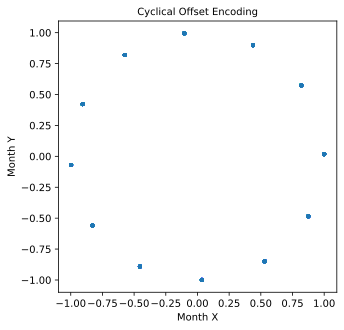

In [33]:
# Plot the month encoding to ensure that was correctly
# captured in the aggregate dataset. For our chosen offsets,
# we should see 12 equally spaced points on a unit circle
ds = StockDataset.from_file(f'data/train-full.npz')

x = [train_ds[i][0][0][-2] for i in range(len(train_ds)) ]
y = [train_ds[i][0][0][-1] for i in range(len(train_ds)) ]

plt.figure(figsize=(5,5))
plt.title('Cyclical Offset Encoding')
plt.xlabel('Month X')
plt.ylabel('Month Y')
plt.plot(x,y,marker='.',linestyle='');

### Automation
Concatenate the code associated with the data generator functions (4 functions) that generate labels and categorical, daily and quarterly data for each stock. This will allow us to use the code later for our prediction engine without having to copy-paste from the notebook.

In [34]:
# Generate a file for the categorical, daily and quarterly functions to be used by the prediction code
!cat tmp_imports tmp_predictor_categorical tmp_predictor_daily tmp_predictor_quarterly > ./model/predictor_helper.py
!cat tmp_imports tmp_benchmark_sp500_gain tmp_benchmark_label > ./model/benchmark_helper.py

In [35]:
# Generate a file for benchmarking (gets S&P 500 gains)
!rm  tmp_imports tmp_predictor_categorical tmp_predictor_daily tmp_predictor_quarterly
!rm  tmp_benchmark_sp500_gain tmp_benchmark_label